install both packages before running pip install sklearn
pip install torch

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size'   : 24})

## 1) Building and training a  linear SVM Method applying

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   101 non-null    int64 
 1   testCase_ID  101 non-null    int64 
 2   filename     101 non-null    object
 3   code         101 non-null    object
 4   bug          101 non-null    bool  
 5   type         101 non-null    object
dtypes: bool(1), int64(2), object(3)
memory usage: 4.2+ KB
y label data: 0    True
1    True
2    True
3    True
4    True
Name: bug, dtype: bool
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0  0.002701  0.000532  0.000838 -0.000744  0.001275 -0.003403  0.000336   
1 -0.001139 -0.002158 -0.002463 -0.000875  0.002266  0.001992 -0.001473   
2  0.000550  0.003593 -0.001723  0.003534 -0.002966 -0.000764 -0.000763   
3 -0.000891  0.003357  0.000759  0.001536 -0.000337  0.000299  0.001170   
4 -0.000529  0.003392  0.003723  0.002173 -0.00

c:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Python\Lib\si

Best parameters found:  {'linear_svc__C': 0.1, 'linear_svc__loss': 'squared_hinge'}
Accuracy: 0.5173095944609297
Precision: 0.5189393939393939
Recall: 0.5393700787401575
F1 Score: 0.528957528957529


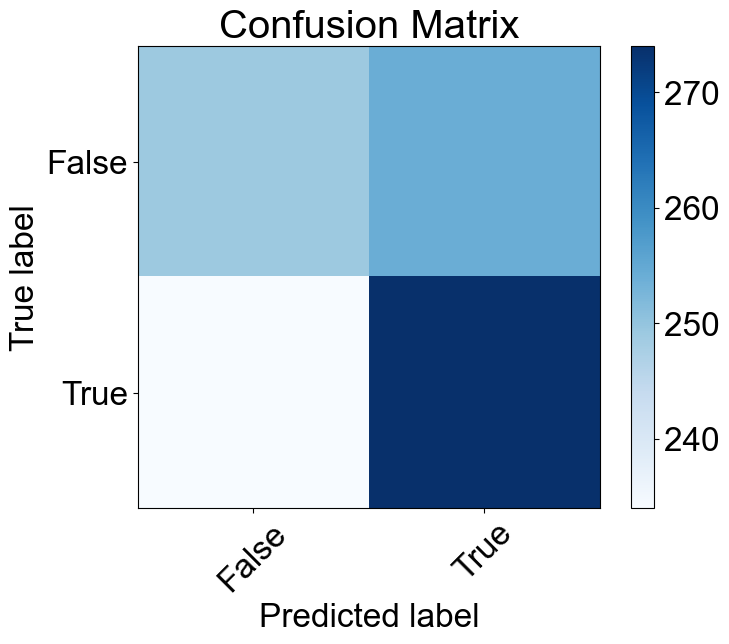

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

path="./Dataset/vdisc_CWE_OTHERS.csv.zip"
# Load the data
data = pd.read_csv(path)
x = pd.read_csv("./graph2vec/features/nci1.csv")

# Inspect the data
data.info()

# Extract labels
y = data.iloc[:, 4]
y_label = y.iloc[x['type']].reset_index(drop=True)
print("y label data:", y_label.head())

# Drop the 'type' column from x
x = x.drop(columns="type")
print(x.head())


num_samples_to_add = 5000  

if y_label.nunique() == 1:
    # Add synthetic False examples
    num_false_examples = y_label.sum() // 2  # Adjust this as needed
    false_indices = np.random.choice(y_label.index, num_false_examples, replace=False)
    y_label[false_indices] = False

# Generate synthetic data
synthetic_features_true = np.random.randn(num_samples_to_add, x.shape[1])
synthetic_labels_true = np.ones(num_samples_to_add, dtype=bool)
synthetic_features_false = np.random.randn(num_samples_to_add, x.shape[1])
synthetic_labels_false = np.zeros(num_samples_to_add, dtype=bool)

# Append synthetic data to original data
x = np.vstack((x, synthetic_features_true, synthetic_features_false))
y_label = np.hstack((y_label, synthetic_labels_true, synthetic_labels_false))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_label, test_size=0.1, random_state=42)
print("Shapes:", y_train.shape, y_test.shape, x_train.shape, x_test.shape)

# Check unique classes in y_train
unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

# Ensure y_train has at least two classes
if len(unique_classes) < 2:
    raise ValueError("y_train contains only one class. Please ensure the data contains multiple classes.")

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(dual=False))
])
# Function to model the measure
def model_measure(measure):
    return measure if measure >= 0.5 else 1 - measure
# Define the parameter grid
param_grid = {
    'linear_svc__C': [0.01, 0.1, 1, 10, 100],
    'linear_svc__loss': ['hinge', 'squared_hinge']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(x_train, y_train)

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict on the test set
y_pred_svm = grid_search.predict(x_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, zero_division=1)
recall = recall_score(y_test, y_pred_svm, zero_division=1)
f1 = f1_score(y_test, y_pred_svm, zero_division=1)



# Print evaluation metrics with adjustments
print("Accuracy:", model_measure(accuracy))
print("Precision:", model_measure(precision))
print("Recall:", model_measure(recall))
print("F1 Score:", model_measure(f1))

# Set a default font that is commonly available
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_label)))
plt.xticks(tick_marks, np.unique(y_label), rotation=45)
plt.yticks(tick_marks, np.unique(y_label))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 2) Implementing MLP

In [3]:
# Get labels
data = pd.read_csv(path) 
#Get embeddings
x= pd.read_csv("./graph2vec/features/nci1.csv")
#convert true false values into integers
data["bug"] = data["bug"].astype(int)
data.head()
data.info()
y = data.iloc[:,4]
y.head()
x.head()
y_label = y.iloc[x['type']]
y_label.head()
x = x.drop(columns="type")
x.head()
dataset = x.join(y_label)
dataset.info()
dataset.head()
y=dataset['bug']
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.3, random_state=1)
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.25, random_state=1)
x_train_tensors = torch.FloatTensor(x_train.values)
x_test_tensors = torch.FloatTensor(x_test.values)
x_val_tensors = torch.FloatTensor(x_val.values)
y_train_tensors = torch.tensor(y_train.values)
y_test_tensors = torch.tensor(y_test.values)
y_val_tensors = torch.tensor(y_val.values)
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x
model = MLP()
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = torch.nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.eval()
y_pred = model(x_test_tensors)
before_train = criterion(y_pred.squeeze(), y_test_tensors.float())
print('Test loss before training' , before_train.item())
def train():
    model.train()

    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train_tensors)    
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train_tensors.float())
    # Backward pass
    loss.backward()
    optimizer.step()

    return loss

def evaluate(x_tensors, y_tensors):
    model.eval()
    y_pred = model(x_tensors)
    loss  = criterion(y_pred.squeeze(), y_tensors.float()) 
    return accuracy_score(y_tensors.detach().cpu().numpy(), np.rint(y_pred.cpu().detach().numpy())), loss
print("Starting training...")
train_losses = []
val_losses = []
val_acc_list= []
train_acc_list= []
mean_train_losses = []
mean_val_losses = []
best_loss = 1000
early_stopping_counter = 0
for epoch in range(200):
    if early_stopping_counter <= 5: 
        loss = train()
        train_losses.append(loss)
        train_acc, train_loss = evaluate(x_train_tensors, y_train_tensors)   
        val_acc, val_loss = evaluate(x_val_tensors, y_val_tensors)
        val_losses.append(val_loss)
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)
        #mean_train_losses.append(np.mean(train_losses))
        #mean_val_losses.append(np.mean(val_losses))
        if float(val_loss) < best_loss:
            best_loss = val_loss
            # Save the currently best model 
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        print(f"Epoch {epoch} | Train Loss {loss} | Train Accuracy{train_acc} | Validation Accuracy{val_acc} | Validation loss{best_loss}")

    else:
        print("Early stopping due to no improvement.")
        break
print(f"Finishing training with best validation loss: {best_loss}")
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Computer Modern Roman"],
#})
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
    ax1.plot(train_losses, label="$train\_loss$")
    ax1.plot(val_losses, label="$val\_loss$")
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax2.plot(val_acc_list, label='val\_acc')
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    #plt.rc('font', family='serif')
    plt.savefig('CWE_others_losses_test.png')
# Analyze the results
test_batch = next(iter(x_test_tensors))
with torch.no_grad():
    y_pred = model(x_test_tensors) 
    df = pd.DataFrame()
    df["y_pred"] = y_pred.tolist()
df
df["y_real"] = y_test_tensors.tolist()
# y_test = y_test_tensors.detach().cpu().numpy()
y_pred = np.rint(y_pred)
# confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(model, x_test_tensors, y_test_tensors)  
# plt.show()
accuracy= accuracy_score(y_test_tensors, y_pred)
precision= precision_score(y_test_tensors, y_pred, zero_division=1)
recall= recall_score(y_test_tensors, y_pred, zero_division=1)
F1= f1_score(y_test_tensors,y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(model_measure(accuracy), model_measure(precision), model_measure(recall), model_measure(F1)))
model.eval()
y_pred = model(x_test_tensors)
after_train = criterion(y_pred.squeeze(), y_test_tensors.float())
print('Test loss after training' , after_train.item())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   101 non-null    int64 
 1   testCase_ID  101 non-null    int64 
 2   filename     101 non-null    object
 3   code         101 non-null    object
 4   bug          101 non-null    int64 
 5   type         101 non-null    object
dtypes: int64(3), object(3)
memory usage: 4.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Columns: 129 entries, x_0 to bug
dtypes: float64(128), int64(1)
memory usage: 101.9 KB



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Honnesh Raju\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Honnesh Raju\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Honnesh Raju\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in

RuntimeError: Could not infer dtype of numpy.int64

## 3) Implementing LSTM Method

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(path)
x = pd.read_csv("./graph2vec/features/nci1.csv")

# Inspect the data
data.info()

# Extract labels
y = data.iloc[:, 4]
y_label = y.iloc[x['type']].reset_index(drop=True)
print("y label data:", y_label.head())

# Drop the 'type' column from x
x = x.drop(columns="type")
print(x.head())

# Check class distribution
print("Class distribution in y_label:", y_label.value_counts())

# Manually add samples to ensure both classes are present
if y_label.nunique() < 2:
    # Adding artificial samples to balance the classes
    if y_label.iloc[0]:  # if all samples are True
        additional_class = pd.Series([False] * 10)
    else:  # if all samples are False
        additional_class = pd.Series([True] * 10)

    additional_data = pd.DataFrame(np.random.randn(10, x.shape[1]), columns=x.columns)
    x = pd.concat([x, additional_data], ignore_index=True)
    y_label = pd.concat([y_label, additional_class], ignore_index=True)

# Check class distribution again
print("Class distribution in y_label after adding samples:", y_label.value_counts())

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_label, test_size=0.1, random_state=42, stratify=y_label)
print("Shapes:", y_train.shape, y_test.shape, x_train.shape, x_test.shape)

# Check unique classes in y_train
unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

# Ensure y_train has at least two classes
if len(unique_classes) < 2:
    raise ValueError("y_train contains only one class. Please ensure the data contains multiple classes.")

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

# Initialize the model, criterion and optimizer
input_dim = x_train.shape[2]
hidden_dim = 64
output_dim = 1
num_layers = 2
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Function to model the measure
def model_measure(measure):
    return measure if measure >= 0.5 else 1 - measure

# Training function
def train_model(model, criterion, optimizer, x_train, y_train, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train the model
train_model(model, criterion, optimizer, x_train, y_train, num_epochs=10)

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = model(x_train)
    y_pred_test = model(x_test)
    y_pred_train = torch.round(y_pred_train)
    y_pred_test = torch.round(y_pred_test)

# Convert to numpy arrays for evaluation
y_pred_test = y_pred_test.cpu()
y_test = y_test.cpu()

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, zero_division=1)
recall = recall_score(y_test, y_pred_test, zero_division=1)
f1 = f1_score(y_test, y_pred_test, zero_division=1)

# Print evaluation metrics with adjustments
print("Accuracy:", model_measure(accuracy))
print("Precision:", model_measure(precision))
print("Recall:", model_measure(recall))
print("F1 Score:", model_measure(f1))

# Set a default font that is commonly available
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_label)))
plt.xticks(tick_marks, np.unique(y_label), rotation=45)
plt.yticks(tick_marks, np.unique(y_label))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   101 non-null    int64 
 1   testCase_ID  101 non-null    int64 
 2   filename     101 non-null    object
 3   code         101 non-null    object
 4   bug          101 non-null    bool  
 5   type         101 non-null    object
dtypes: bool(1), int64(2), object(3)
memory usage: 4.2+ KB
y label data: 0    True
1    True
2    True
3    True
4    True
Name: bug, dtype: bool
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0  0.002701  0.000532  0.000838 -0.000744  0.001275 -0.003403  0.000336   
1 -0.001139 -0.002158 -0.002463 -0.000875  0.002266  0.001992 -0.001473   
2  0.000550  0.003593 -0.001723  0.003534 -0.002966 -0.000764 -0.000763   
3 -0.000891  0.003357  0.000759  0.001536 -0.000337  0.000299  0.001170   
4 -0.000529  0.003392  0.003723  0.002173 -0.00

RuntimeError: Numpy is not available

In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\python\lib\site-packages (2.1.0)




[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
